Using matplotlib as 2D backend.


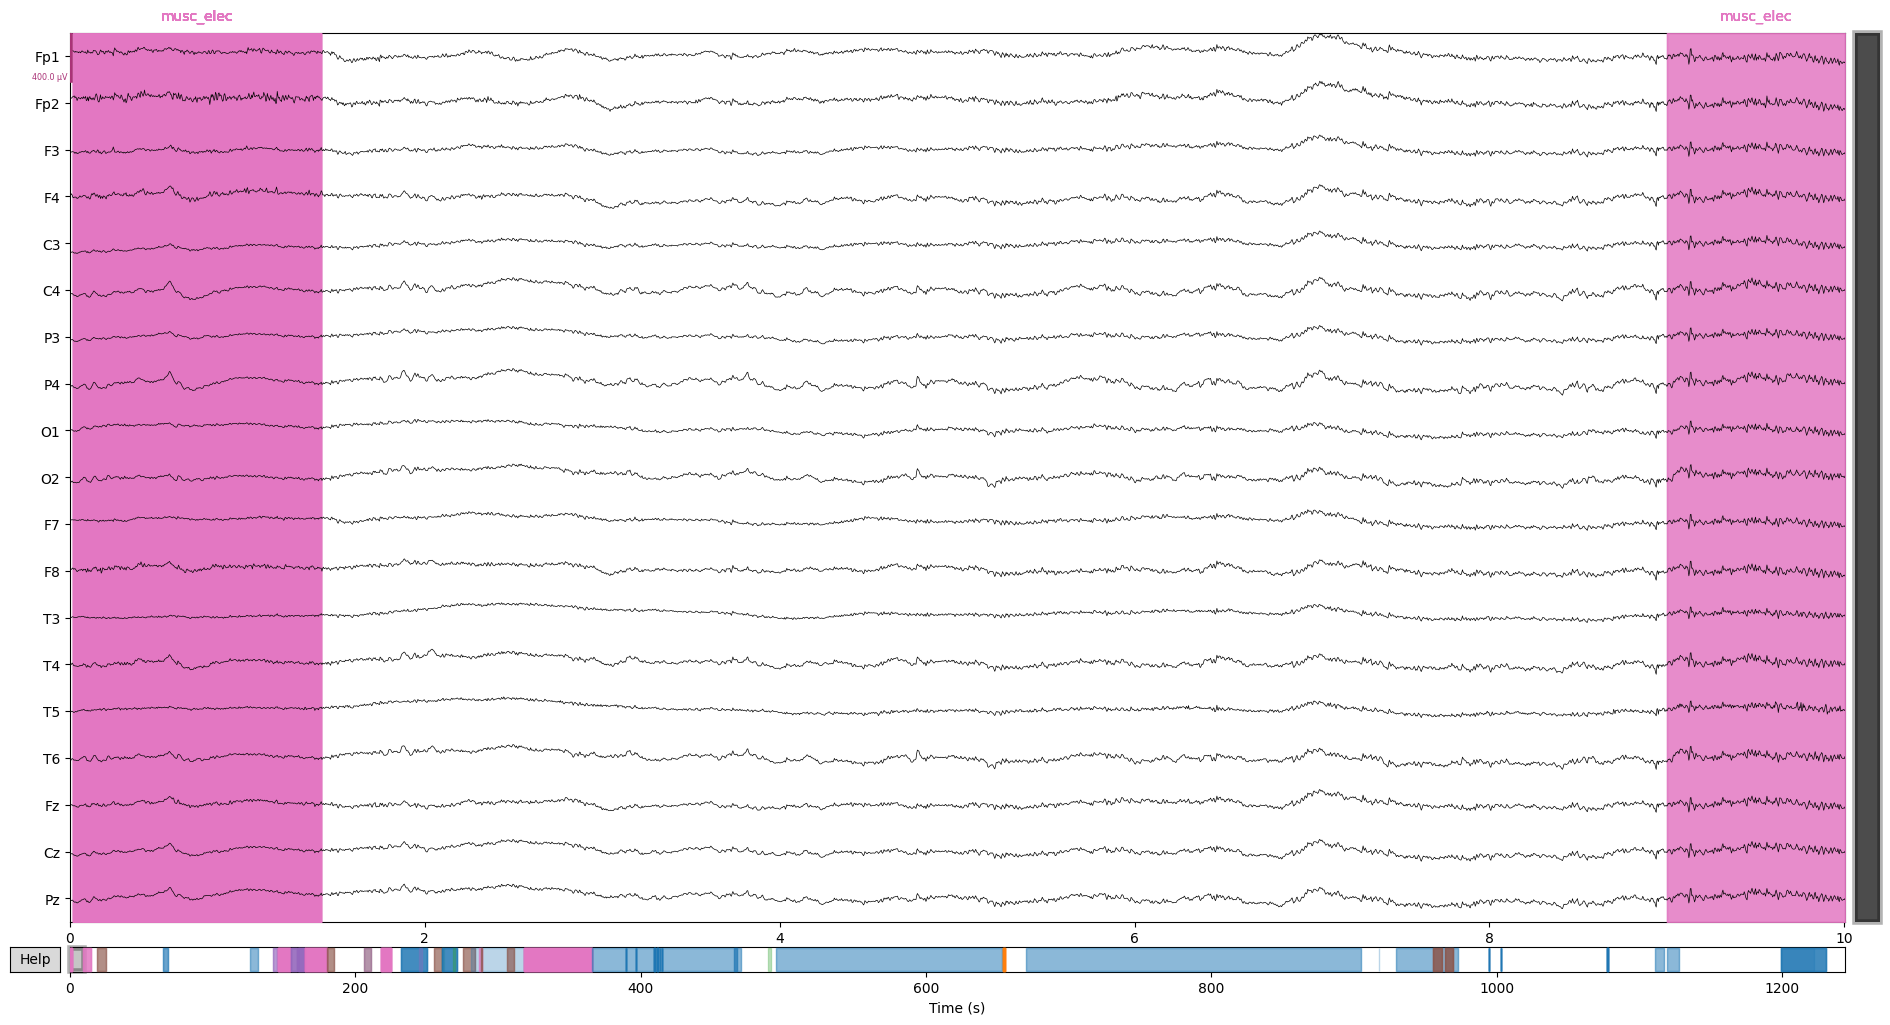

In [2]:
import mne
import pandas as pd
import matplotlib.pyplot as plt
import os
%matplotlib qt

edf_file = "v3.0.1/edf/01_tcp_ar/aaaaaaju_s007_t000.edf"
annotations_file = "v3.0.1/edf/01_tcp_ar/aaaaaaju_s007_t000.csv"

if not os.path.exists(edf_file):
    raise FileNotFoundError(f"El archivo EDF no se encontró en la ruta: {edf_file}")
if not os.path.exists(annotations_file):
    raise FileNotFoundError(f"El archivo de anotaciones no se encontró en la ruta: {annotations_file}")

channel_mapping = {
    'EEG FP1-REF': 'Fp1', 'EEG FP2-REF': 'Fp2',
    'EEG F3-REF': 'F3', 'EEG F4-REF': 'F4',
    'EEG C3-REF': 'C3', 'EEG C4-REF': 'C4',
    'EEG P3-REF': 'P3', 'EEG P4-REF': 'P4',
    'EEG O1-REF': 'O1', 'EEG O2-REF': 'O2',
    'EEG F7-REF': 'F7', 'EEG F8-REF': 'F8',
    'EEG T3-REF': 'T3', 'EEG T4-REF': 'T4',
    'EEG T5-REF': 'T5', 'EEG T6-REF': 'T6',
    'EEG FZ-REF': 'Fz', 'EEG CZ-REF': 'Cz',
    'EEG PZ-REF': 'Pz'
}

raw = mne.io.read_raw_edf(edf_file, preload=True, verbose='ERROR')

channels_to_keep = [ch for ch in raw.ch_names if ch in channel_mapping]
raw.pick(channels_to_keep)

raw.rename_channels(channel_mapping)

annotations_df = pd.read_csv(annotations_file, comment='#')

annotation_mapping = {ch.split()[1]: new_name for ch, new_name in channel_mapping.items()}

def map_annotation_channel(channel):
    try:
        ch1, ch2 = channel.split('-')
        mapped_ch1 = annotation_mapping.get(ch1, ch1)
        mapped_ch2 = annotation_mapping.get(ch2, ch2)
        return f"{mapped_ch1}-{mapped_ch2}"
    except ValueError:
        return channel

annotations_df['channel'] = annotations_df['channel'].map(map_annotation_channel)

valid_channels = [f"{ch1}-{ch2}" for ch1 in annotation_mapping.values() for ch2 in annotation_mapping.values()]
annotations_df = annotations_df[annotations_df['channel'].isin(valid_channels)]

annotations = mne.Annotations(
    onset=annotations_df['start_time'].values,
    duration=(annotations_df['stop_time'] - annotations_df['start_time']).values,
    description=annotations_df['label'].values
)

raw.set_annotations(annotations)

raw.plot(
    n_channels=len(raw.ch_names),
    scalings=dict(eeg=20e-5),
    title='EEG with Channel Mapping and Annotations',
    show=True,
    group_by='original',
    remove_dc=False
)
